# URL Phishing Detection

In this notebook, we aim to build a machine learning model that can accurately classify URLs as either **malicious (phishing)** or **benign (legitimate)** based on their structural characteristics. Unlike natural language processing approaches used for email body content, URLs require a feature-engineering-based strategy, focusing on patterns like length, presence of suspicious keywords, number of dots or slashes, and more.

We'll use the **Malicious URLs Dataset** from Kaggle, extract relevant features from each URL, train a classification model, evaluate its performance, and save the best-performing model for production use in our unified phishing detection system.

📌 **Goal**: Achieve at least **95% accuracy** in detecting phishing URLs, while maintaining low false positives to ensure reliability in real-world scenarios.

**Imports**:

In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
import re

# Model Training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Model Saving
import joblib

# Plot Style
sns.set_style('dark')

**Load the Dataset**:

In [2]:
# Load the Dataset
df = pd.read_csv('../data/malicious_phish.csv')
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


## Exploratory Data Analysis (EDA)

In this section, we will perform Exploratory Data Analysis (EDA) to better understand the structure and distribution of the dataset. We'll examine the balance between phishing and benign URLs, check for missing values, and identify any patterns or inconsistencies that could influence feature extraction. This step ensures we have a clear understanding of the data before moving into feature engineering and model training.

**Basics**:

In [3]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [5]:
df.describe()

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [6]:
df.isna().sum()

url     0
type    0
dtype: int64

In [7]:
df['url'].duplicated().sum()

np.int64(10072)

The dataset contains **651,191 URL entries** across two columns: `url` and `type`. There are **no missing values**, but we found **10,072 duplicate URLs**, which we may choose to remove to avoid bias. The `type` column has four unique values, with `'benign'` being the most frequent, appearing over 428,000 times. Before moving on, we’ll explore the label distribution and decide whether to filter or merge any classes for binary classification (e.g., phishing vs. non-phishing).

In [8]:
df['type'].unique()

array(['phishing', 'benign', 'defacement', 'malware'], dtype=object)

The `type` column contains four categories: `'phishing'`, `'malware'`, `'defacement'`, and `'benign'`. Since our goal is to classify URLs as either **malicious** or **legitimate**, we will convert this into a binary classification task. Specifically, `'phishing'`, `'malware'`, and `'defacement'` will be grouped under the **malicious** class (label `1`), while `'benign'` will remain as **legitimate** (label `0`). This approach simplifies the task and aligns with our existing email phishing detection model.

In [9]:
df['url_length'] = df['url'].apply(len)

**Drop the Duplicates**:

In [10]:
df = df.drop_duplicates(subset='url')
df['url'].duplicated().sum()

np.int64(0)

**Encode the Type**:

In [11]:
df.loc[:, 'label'] = df['type'].apply(lambda x: 0 if x=='benign' else 1)
df['label'].unique()

array([1, 0])

In [12]:
df = df.drop(columns=['type'])

In [13]:
df['label'].value_counts(normalize=True) * 100

label
0    66.770756
1    33.229244
Name: proportion, dtype: float64

In [14]:
df.head()

,url,url_length,label
0,br-icloud.com.br,16,1
1,mp3raid.com/music/krizz_kaliko.html,35,0
2,bopsecrets.org/rexroth/cr/1.htm,31,0
3,http://www.garage-pirenne.be/index.php?option=...,88,1
4,http://adventure-nicaragua.net/index.php?optio...,235,1


We have succesfully dropped the duplicates and encode the label!

**Visualization**:

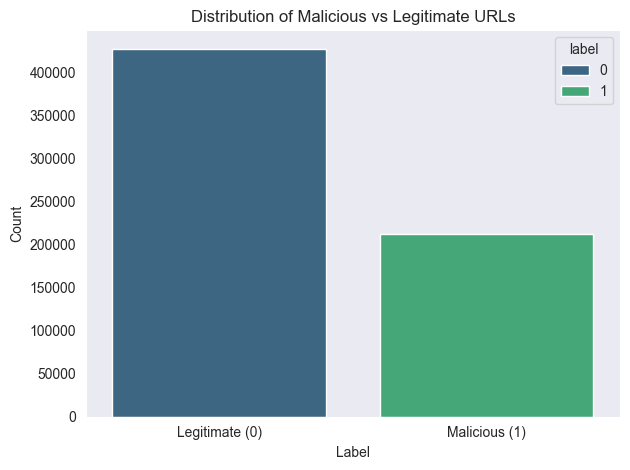

In [15]:
label_counts = df['label'].value_counts()

# Create Bar Plot
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette='viridis')
plt.title('Distribution of Malicious vs Legitimate URLs')
plt.ylabel('Count')
plt.xlabel('Label')
plt.xticks([0, 1], ['Legitimate (0)', 'Malicious (1)'])
plt.tight_layout()

# Save the plot
plt.savefig(fname='../images/Distribution_Malicious_vs_Legitimate_URLs.png')

# Show the plot
plt.show()

The dataset is not fully balanced, but we do have enough malicious URLs

In [16]:
df.head()

,url,url_length,label
0,br-icloud.com.br,16,1
1,mp3raid.com/music/krizz_kaliko.html,35,0
2,bopsecrets.org/rexroth/cr/1.htm,31,0
3,http://www.garage-pirenne.be/index.php?option=...,88,1
4,http://adventure-nicaragua.net/index.php?optio...,235,1


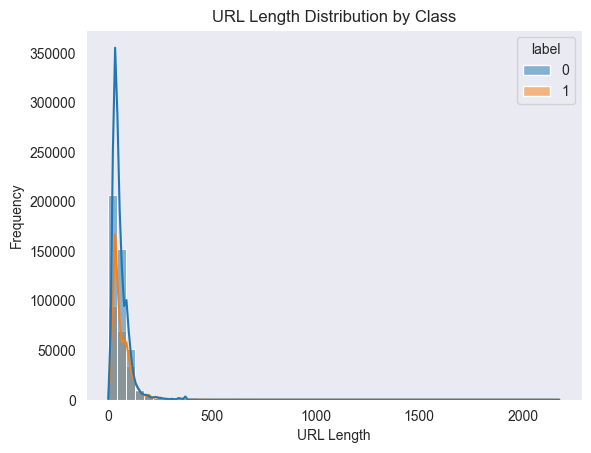

In [17]:
# Create Histogram Plot
sns.histplot(data=df, x='url_length', hue='label', kde=True, bins=50)
plt.title('URL Length Distribution by Class')
plt.xlabel('URL Length')
plt.ylabel('Frequency')

# Save as Image
plt.savefig(fname='../images/URL_Length_Distribution_By_Class.png')

# Show the Plot
plt.show()

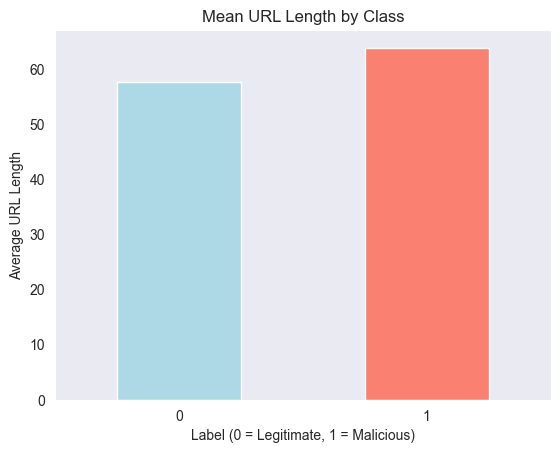

In [18]:
# Get the mean of the URL length based on the label
mean_length = df.groupby('label')['url_length'].mean()

# Plot
mean_length.plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Mean URL Length by Class')
plt.xlabel('Label (0 = Legitimate, 1 = Malicious)')
plt.ylabel('Average URL Length')
plt.xticks(rotation=0)

# Save as Image
plt.savefig(fname='../images/Mean_URL_Length_By_Class.png')

# Show the Plot
plt.show()